# Automatic Differentiation

## Installing Autograd

You need to install Autograd by typing ```conda install --channel conda-forge autograd``` in your console. We will test it on toy function.

In [1]:
import autograd.numpy as np
from autograd import elementwise_grad
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return np.abs(x)

gradient_f = elementwise_grad(f)

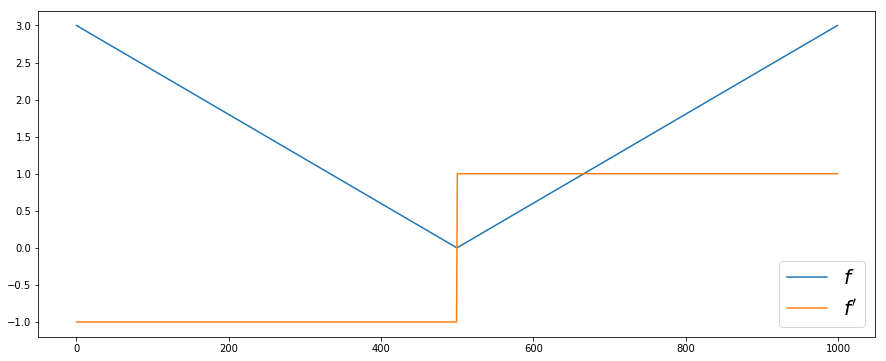

In [3]:
x = np.linspace(-3,3,1000)
plt.figure(figsize=(15,6))
plt.plot(f(x), label='$f$')
plt.plot(gradient_f(x), label="$f'$")
plt.legend(fontsize=20)
plt.show()

## Application to Neural Network training: Geographical Origins of Music

In [15]:
import autograd.numpy as np
from autograd import grad
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Loading the data

The goal of this exercise is to train a two-layer feed-forward neural network in a regression problem. The data consists of music features and location. The goal is to retrieve the spatial origin of a music piece using the music features.

In [16]:
# Load the Geographical Origins of Music dataset
data = pd.read_table('Geographical Original of Music/default_plus_chromatic_features_1059_tracks.txt', sep=',', header=None)
data.rename(columns={116:'Latitude', 117:'Longitude'}, inplace=True)

We split the dataset in two : a train dataset with 80% of the data, and a test data set with the remaining 20% of the data.

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-2], data.iloc[:,-2:], test_size=0.20, random_state=42)

Let us plot the geographical repartition in the train and test datasets.

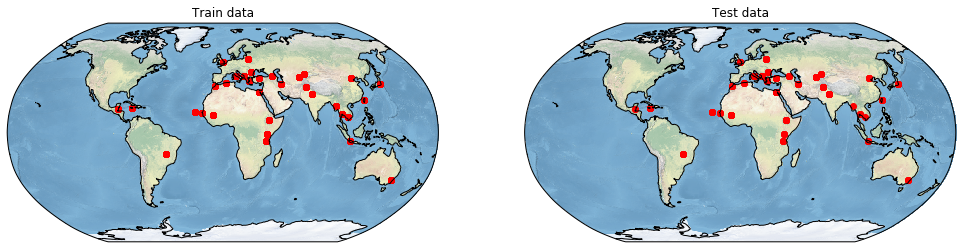

In [18]:
fig = plt.figure(figsize=(17, 13))

# Train data
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson())

ax.stock_img()
ax.coastlines()

ax.set_title('Train data')
ax.scatter(y_train['Longitude'], y_train['Latitude'], c='r', transform=ccrs.Geodetic())

# Test data
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Robinson())

ax2.stock_img()
ax2.coastlines()

ax2.set_title('Test data')
ax2.scatter(y_test['Longitude'], y_test['Latitude'], c='r', transform=ccrs.Geodetic())

plt.show()

### Prediction of Longitude/Latitude with a 2-layer neural network

We implement the two-layaer neural network.

In [50]:
# Size of the neural network layers
size_features = X_train.shape[1]
size_hidden_layer = 20
size_prediction = 2

In [51]:
# Compute the min and max of the Latitudes and Longitudes in the train dataset
# This will be useful for rescaling the output of the neural network
min_latitude = y_train['Latitude'].min()
max_latitude = y_train['Latitude'].max()
min_longitude = y_train['Longitude'].min()
max_longitude = y_train['Longitude'].max()

In [52]:
# Define the targets and inputs of the neural network
targets = np.array(y_train)
inputs = np.array(X_train.T)

In [53]:
def network(inputs, A1, A2, b1, b2, sgd=False):
    '''Return the predicted value for features x with a 2-layer neural network of parameters A1 and A2 and biases b1 and b2.'''
    assert inputs.shape[0] == A1.shape[1]
    assert A2.shape == (2, A1.shape[0])
    if sgd: # If only one data is to be computed
        [latitude, longitude] = b2 + np.tanh(np.dot(A2, b1 + np.tanh(np.dot(A1, inputs))))
    else: # If the network has to compute several outputs 
        [latitude, longitude] = np.repeat(b2, inputs.shape[1]).reshape(b2.shape[0],-1) \
                                + np.tanh(np.dot(A2, np.repeat(b1, inputs.shape[1]).reshape(b1.shape[0],-1) \
                                + np.tanh(np.dot(A1, inputs))))
    latitude = min_latitude + 0.5*(latitude+1)*(max_latitude - min_latitude)
    longitude = min_longitude + 0.5*(longitude+1)*(max_longitude - min_longitude)
    return np.array([latitude, longitude]).T

In [54]:
def loss(y_pred, y_true):
    '''Return the arc-cosine distance on the Earth between y_pred and y_true.'''
    latitude_pred, longitude_pred = y_pred*np.pi/180.
    latitude_true, longitude_true = y_true*np.pi/180.
    delta_latitude = latitude_pred - latitude_true
    delta_longitude = longitude_pred - longitude_true
    R = 6371
    return 2*R*np.arcsin(np.sqrt( np.sin(0.5*delta_latitude)**2 \
                                 + np.cos(latitude_pred)*np.cos(latitude_true)*np.sin(0.5*delta_longitude)**2 ))

In [55]:
def objective(weights):
    '''Compute the objective to be minimized by the network using a gradient descent approach.'''
    A1, A2, b1, b2 = weights
    pred = network(inputs, A1, A2, b1, b2)
    return np.sum([loss(pred[i], targets[i]) for i in range(inputs.shape[1])])/inputs.shape[1]

In [56]:
def objective_sgd(weights):
    '''Compute the objective to be minimized by the network using a stochastic gradient descent approach.'''
    A1, A2, b1, b2 = weights
    i = np.random.randint(inputs.shape[1])
    pred = network(inputs[:,i], A1, A2, b1, b2, sgd=True)
    return loss(pred, targets[i])

In [57]:
def objective_test(weights):
    '''Compute the objective for the test dataset.'''
    A1, A2, b1, b2 = weights
    pred = network(X_test.T, A1, A2, b1, b2)
    return np.sum([loss(pred[i], y_test.iloc[i,:]) for i in range(X_test.shape[0])])/X_test.shape[0]

#### Gradient Descent

We fist use a Gradient Descent approach to minimize the loss function

In [58]:
np.random.seed(0)

epochs = 40 # Number of epochs to be ran by the Gradient Descent algorithm
learning_rate = 0.00005

# Initialize the weights and biases of the network
A1 = np.random.randn(size_hidden_layer, size_features)
A2 = np.random.randn(size_prediction, size_hidden_layer)
b1 = np.random.randn(size_hidden_layer)
b2 = np.random.randn(size_prediction)

# Compute the gradient of the objective
grad_loss = grad(objective)

train_loss_history = []
test_loss_history = []
print('Iteration', '|', 'Train loss', '|', 'Test loss')
for t in range(epochs):
    train_loss_history.append(objective([A1,A2,b1,b2]))
    test_loss_history.append(objective_test([A1,A2,b1,b2]))
    print(t, '        | ', int(train_loss_history[-1]), 'km   | ', int(test_loss_history[-1]), 'km')
    # Compute the gradients
    grad_A1, grad_A2, grad_b1, grad_b2 = grad_loss([A1, A2, b1, b2])
    
    # Update the weights and biases
    A1 = A1 - learning_rate * grad_A1
    A2 = A2 - learning_rate * grad_A2
    b1 = b1 - learning_rate * grad_b1
    b2 = b2 - learning_rate * grad_b2

# Save the weights and biases
A1_GD, A2_GD, b1_GD, b2_GD = A1, A2, b1, b2

Iteration | Train loss | Test loss
0         |  10063 km   |  10366 km
1         |  8983 km   |  9340 km
2         |  7898 km   |  8199 km
3         |  6997 km   |  7207 km
4         |  6484 km   |  6513 km
5         |  6084 km   |  6049 km
6         |  5764 km   |  5698 km
7         |  5601 km   |  5444 km
8         |  5481 km   |  5276 km
9         |  5370 km   |  5147 km
10         |  5258 km   |  5016 km
11         |  5157 km   |  4898 km
12         |  5064 km   |  4780 km
13         |  4980 km   |  4667 km
14         |  4906 km   |  4560 km
15         |  4844 km   |  4475 km
16         |  4789 km   |  4403 km
17         |  4738 km   |  4341 km
18         |  4690 km   |  4287 km
19         |  4645 km   |  4239 km
20         |  4606 km   |  4201 km
21         |  4577 km   |  4174 km
22         |  4555 km   |  4154 km
23         |  4540 km   |  4138 km
24         |  4537 km   |  4157 km
25         |  4518 km   |  4116 km
26         |  4520 km   |  4142 km
27         |  4502 km   |  4

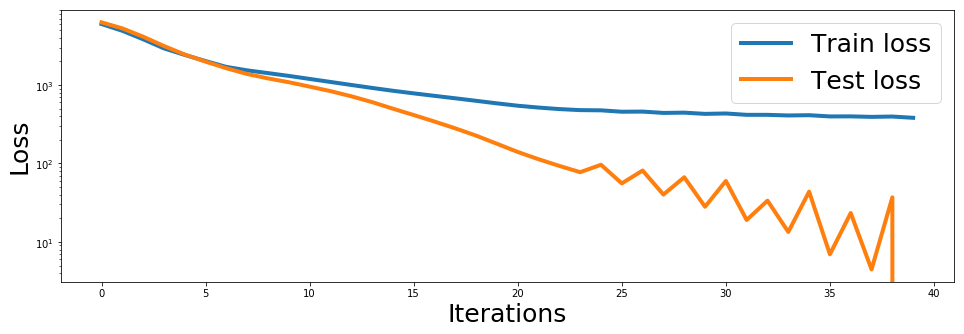

In [59]:
min_objective = min([min(train_loss_history), min(test_loss_history)])
plt.figure(figsize=(16,5))
plt.semilogy(train_loss_history-min_objective, lw=4, label='Train loss')
plt.semilogy(test_loss_history-min_objective, lw=4, label='Test loss')
plt.xlabel('Iterations', fontsize=25)
plt.ylabel('Loss', fontsize=25)
plt.legend(fontsize=25)
plt.show()

#### Stochastic Gradient Descent

As we observe that the convergence of the Gradient Descent approach is slow, we also try a Stochastic Gradient Descent Approach. Since the objective is non convex, a stochastic approach will more likely avoid being stuck in local minima.
We use a decaying learning rate in $1/\sqrt{t}$ where $t$ is the number of iterations, and a Polyak-Ruppert averaging. This will always be the case in the rest of this notebook.

Since the Stochastic Gradient Descent approach seems to converge way faster than the Gradient Descent approach in this case, we do not use the sae number of epochs : the SGD algorithm will use less data in this very application.

In [60]:
np.random.seed(0)

epochs = 10 # Number of passes over the data
learning_rate = 0.00005

# Initialize the weights and biases of the network
A1 = np.random.randn(size_hidden_layer, size_features)
A2 = np.random.randn(size_prediction, size_hidden_layer)
b1 = np.random.randn(size_hidden_layer)
b2 = np.random.randn(size_prediction)

# Initialize the averaged weights and biases of the network
A1_moy = np.copy(A1)
A2_moy = np.copy(A2)
b1_moy = np.copy(b1)
b2_moy = np.copy(b2)

# Compute the gradient of the objective
grad_loss = grad(objective_sgd)

train_loss_history = []
test_loss_history = []

print('Number of passes', '|', 'Train loss', '|', 'Test loss')
for t in range(epochs*X_train.shape[0]):
    if t % X_train.shape[0] == 0:
        train_loss_history.append(objective([A1_moy,A2_moy,b1_moy,b2_moy]))
        test_loss_history.append(objective_test([A1_moy,A2_moy,b1_moy,b2_moy]))
        print(int(t/X_train.shape[0]), '             | ', int(train_loss_history[-1]), 'km   | ', int(test_loss_history[-1]), 'km')
    # Compute the gradients
    grad_A1, grad_A2, grad_b1, grad_b2 = grad_loss([A1, A2, b1, b2])
    
    # Update the weights and biases
    A1 = A1 - learning_rate * (1./np.sqrt(t+1)) * grad_A1
    A2 = A2 - learning_rate * (1./np.sqrt(t+1)) * grad_A2
    b1 = b1 - learning_rate * (1./np.sqrt(t+1))* grad_b1
    b2 = b2 - learning_rate * (1./np.sqrt(t+1))* grad_b2
    
    # Compute the averaged weights and biases
    A1_moy = (t*A1_moy + A1)/(t+1)
    A2_moy = (t*A2_moy + A2)/(t+1)
    b1_moy = (t*b1_moy + b1)/(t+1)
    b2_moy = (t*b2_moy + b2)/(t+1)
    
    
# Save the weights and biases
A1_SGD, A2_SGD, b1_SGD, b2_SGD = A1_moy, A2_moy, b1_moy, b2_moy

Number of passes | Train loss | Test loss
0              |  10063 km   |  10366 km
1              |  4425 km   |  4076 km
2              |  4389 km   |  4048 km
3              |  4386 km   |  4045 km
4              |  4384 km   |  4037 km
5              |  4384 km   |  4035 km
6              |  4385 km   |  4037 km
7              |  4384 km   |  4034 km
8              |  4384 km   |  4035 km
9              |  4383 km   |  4034 km


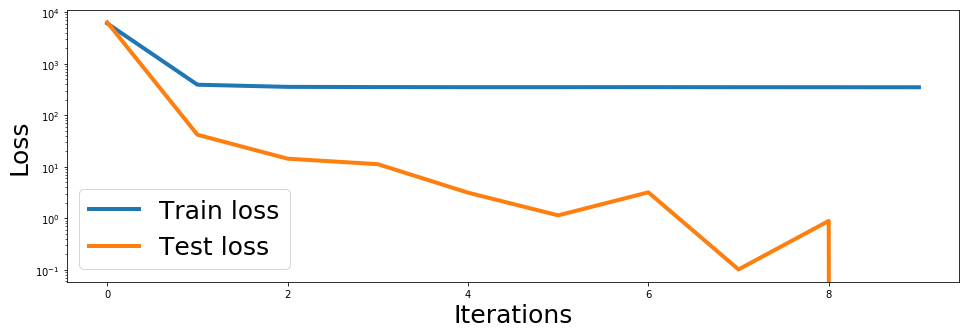

In [61]:
min_objective = min([min(train_loss_history), min(test_loss_history)])
plt.figure(figsize=(16,5))
plt.semilogy(train_loss_history-min_objective, lw=4, label='Train loss')
plt.semilogy(test_loss_history-min_objective, lw=4, label='Test loss')
plt.xlabel('Iterations', fontsize=25)
plt.ylabel('Loss', fontsize=25)
plt.legend(fontsize=25)
plt.show()

#### Results

Let us plot some random test data, and the predicted values for the GD approach and the SGD approach

We can see that in both cases, the network fails to predict correctly the origin of a music piece. The train loss, as well as the test loss, are approximately of 4000km, which is clearly not precise enough. In particular, the network seems to always predict points at the center of the map (Europe/North Africa/Middle East), since this is a good strategy for musics coming from this area (predicting Europe instead of North Africa is cheap in terms of the arc-cosine loss), and not too costly for musics coming from South America/East Asia/Oceania.

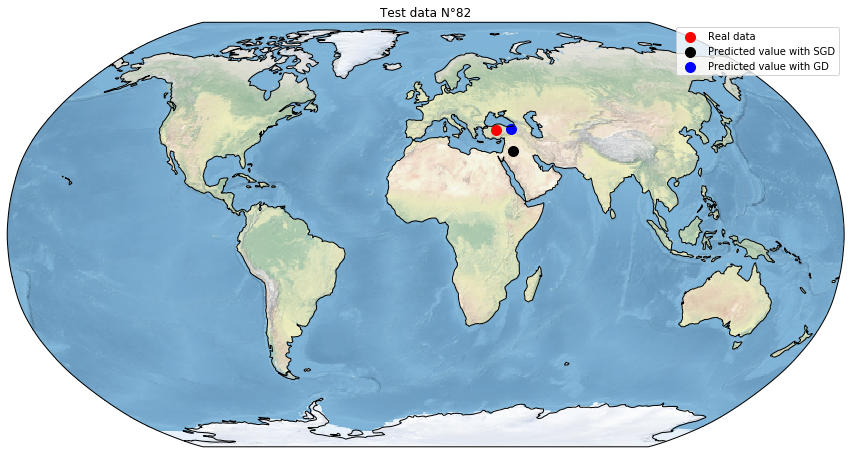

In [67]:
i = np.random.randint(X_test.shape[0])

pred_SGD = network(X_test.iloc[i,:].T, A1_SGD, A2_SGD, b1_SGD, b2_SGD, True)
pred_GD = network(X_test.iloc[i,:].T, A1_GD, A2_GD, b1_GD, b2_GD, True)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.stock_img()
ax.coastlines()

ax.scatter(y_test['Longitude'].iloc[i], y_test['Latitude'].iloc[i], c='r', s=100, transform=ccrs.Geodetic(), label='Real data')
ax.scatter([pred_SGD[0]], [pred_SGD[1]], c='k', transform=ccrs.Geodetic(), s=100, label='Predicted value with SGD')
ax.scatter([pred_GD[0]], [pred_GD[1]], c='b', transform=ccrs.Geodetic(), s=100, label='Predicted value with GD')

ax.set_title('Test data N°'+str(i))

plt.legend()
plt.show()

### Predicting a heatmap

We now wish to predict a heatmap instead of a fixed location.

In [68]:
# Load the music data
data = pd.read_table('Geographical Original of Music/default_plus_chromatic_features_1059_tracks.txt', sep=',', header=None)
data.drop(data.columns[-2:], axis=1, inplace=True)
data = np.array(data)

In [69]:
# Load the geographical maps
maps = np.array(pd.read_table('heatmap.txt', sep='   ', header=None, engine='python'))

In [70]:
# Concatenate music data and geographical maps
data = np.concatenate([data, maps], axis=1)

In [71]:
# Split the dataset in two : train dataset (80% of the data) and a test dataset (the 20% remaining)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[:,:-400], data[:,-400:], test_size=0.20, random_state=42)

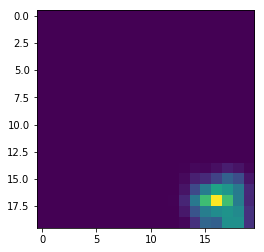

In [72]:
# Plot a random data
i = np.random.randint(y_train.shape[0])
plt.imshow(y_train[i].reshape(20,20))
plt.show()

#### Model

In [73]:
# Size of the neural network layers
size_features = X_train.shape[1]
size_hidden_layer = 100
size_prediction = 400

In [74]:
# Define the targets and inputs of the neural network
targets = np.array(y_train)
inputs = np.array(X_train.T)

In [75]:
def softmax(x):
    '''Return the softmax of vector x.'''
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [76]:
def network(inputs, A1, A2, b1, b2, sgd=False):
    '''Return the predicted value for features x with a 2-layer neural network of weights A1 and A2 and biases b1 and b2.'''
    assert inputs.shape[0] == A1.shape[1]
    assert A2.shape == (400, A1.shape[0])
    if sgd: # If there is only one data to be predicted
        return softmax(b2 + np.dot(A2, b1 + np.tanh(np.dot(A1, inputs))))
    else: # If there is several data to be passed to the network
        return softmax(np.repeat(b2, inputs.shape[1]).reshape(b2.shape[0],-1) +\
                       np.dot(A2, np.repeat(b1, inputs.shape[1]).reshape(b1.shape[0],-1) +\
                       np.tanh(np.dot(A1, inputs))))

#### Gradient Descent with a KL loss

In [77]:
def entropy(p, q):
    '''Return the entropy of p wrt q.'''
    tol = 0.001
    assert p.shape[0] == q.shape[0]
    assert np.prod(q>0) == 1
    return -np.sum(p*np.log(q+tol))
    
def objective_KL(weights):
    '''Compute the objective to be minimized with a KL (entropy) loss and a gradient descent approach.'''
    A1, A2, b1, b2 = weights
    pred = network(inputs, A1, A2, b1, b2)
    return np.sum([entropy(targets[i], pred[:,i]) for i in range(inputs.shape[1])])/inputs.shape[1]

def objective_KL_sgd(weights):
    '''Compute the objective to be minimized with a KL (entropy) loss and a stochastic gradient descent approach.'''
    A1, A2, b1, b2 = weights
    i = np.random.randint(inputs.shape[1])
    pred = network(inputs[:,i], A1, A2, b1, b2, True)
    return entropy(targets[i], pred)

def objective_KL_test(weights):
    '''Compute the objective with a KL (entropy) loss for the test dataset.'''
    A1, A2, b1, b2 = weights
    pred = network(X_test.T, A1, A2, b1, b2)
    return np.sum([entropy(y_test[i], pred[:,i]) for i in range(X_test.shape[1])])/X_test.shape[1]

In [78]:
np.random.seed(0)

epochs = 50 # Number of epochs to be run
learning_rate = 2.

# Initialize the network's weigths and biases
A1 = 0.01*np.random.randn(size_hidden_layer, size_features)
A2 = 0.01*np.random.randn(size_prediction, size_hidden_layer)
b1 = 0.01*np.random.randn(size_hidden_layer)
b2 = 0.01*np.random.randn(size_prediction)

In [79]:
# Compute the gradient of the objective
grad_loss = grad(objective_KL)

train_loss_history = []
test_loss_history = []

print('Iteration', '|', 'Train loss', '         |', 'Test loss')
for t in range(epochs):
    train_loss_history.append(objective_KL([A1,A2,b1,b2]))
    test_loss_history.append(objective_KL_test([A1,A2,b1,b2]))
    print(t, '        | ', train_loss_history[-1], ' | ', test_loss_history[-1])
    
    # Compute the gradients of the parameters
    grad_A1, grad_A2, grad_b1, grad_b2 = grad_loss([A1, A2,b1,b2])
    
    # Run the descent step
    A1 = A1 - learning_rate * grad_A1
    A2 = A2 - learning_rate * grad_A2
    b1 = b1 - learning_rate * grad_b1
    b2 = b2 - learning_rate * grad_b2

# Save the parameters
A1_KL_GD, A2_KL_GD, b1_KL_GD, b2_KL_GD = A1, A2, b1, b2

Iteration | Train loss          | Test loss
0         |  5.6551632657835365  |  5.65470831564745
1         |  5.649066478139271  |  5.647690445565956
2         |  5.642833465846754  |  5.640508391609747
3         |  5.636213375989146  |  5.632876483052953
4         |  5.628932351363626  |  5.624489688652154
5         |  5.62067678277991  |  5.615008833065695
6         |  5.611088546583983  |  5.604059088150837
7         |  5.599783245589425  |  5.591252416733517
8         |  5.586402934424006  |  5.5762436507296265
9         |  5.570711157611927  |  5.558827205130079
10         |  5.552714540432634  |  5.539055123408
11         |  5.532720839158754  |  5.517275048478672
12         |  5.51114255973821  |  5.493885866934786
13         |  5.488069107144759  |  5.468861605087082
14         |  5.463270263879646  |  5.44178435330284
15         |  5.4366937936682636  |  5.412454656750537
16         |  5.40860515543121  |  5.381165256258441
17         |  5.379486411171866  |  5.348671026488006

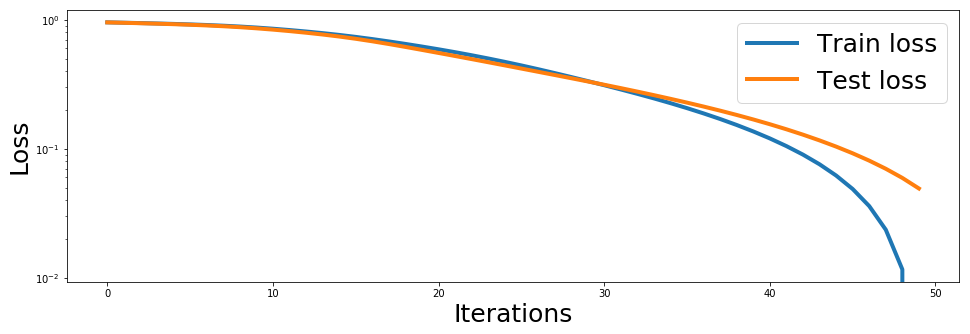

In [80]:
min_objective = min([min(train_loss_history), min(test_loss_history)])
plt.figure(figsize=(16,5))
plt.semilogy(train_loss_history-min_objective, lw=4, label='Train loss')
plt.semilogy(test_loss_history-min_objective, lw=4, label='Test loss')
plt.xlabel('Iterations', fontsize=25)
plt.ylabel('Loss', fontsize=25)
plt.legend(fontsize=25)
plt.show()

#### Stochastic Gradient Descent with a KL loss

In [81]:
np.random.seed(0)

epochs = 50 # Number of passes over the data
learning_rate = 2.

# Initialize the network's parameters
A1 = 0.01*np.random.randn(size_hidden_layer, size_features)
A2 = 0.01*np.random.randn(size_prediction, size_hidden_layer)
b1 = 0.01*np.random.randn(size_hidden_layer)
b2 = 0.01*np.random.randn(size_prediction)

# Initialize the averaged parameters
A1_moy = np.copy(A1)
A2_moy = np.copy(A2)
b1_moy = np.copy(b1)
b2_moy = np.copy(b2)

In [82]:
# Compute the gradient of the SGD objective
grad_loss = grad(objective_KL_sgd)

train_loss_history = []
test_loss_history = []

print('Number of passes', '|', 'Train loss', '         |', 'Test loss')
for t in range(epochs*X_train.shape[0]):
    if t % X_train.shape[0] == 0:
        train_loss_history.append(objective_KL([A1_moy,A2_moy,b1_moy,b2_moy]))
        test_loss_history.append(objective_KL_test([A1_moy,A2_moy,b1_moy,b2_moy]))
        print(int(t/X_train.shape[0]), '             | ', train_loss_history[-1], ' | ', test_loss_history[-1])
    
    # Compute the gradients of the parameters
    grad_A1, grad_A2, grad_b1, grad_b2 = grad_loss([A1, A2,b1,b2])
    
    # Run the descent step
    A1 = A1 - learning_rate * (1./np.sqrt(t+1)) * grad_A1
    A2 = A2 - learning_rate * (1./np.sqrt(t+1)) * grad_A2
    b1 = b1 - learning_rate * (1./np.sqrt(t+1)) * grad_b1
    b2 = b2 - learning_rate * (1./np.sqrt(t+1)) * grad_b2
    
    # Run the averaging step
    A1_moy = (t*A1_moy + A1)/(t+1)
    A2_moy = (t*A2_moy + A2)/(t+1)
    b1_moy = (t*b1_moy + b1)/(t+1)
    b2_moy = (t*b2_moy + b2)/(t+1)
    
# Save the parameters
A1_KL_SGD, A2_KL_SGD, b1_KL_SGD, b2_KL_SGD = A1_moy, A2_moy, b1_moy, b2_moy

Number of passes | Train loss          | Test loss
0              |  5.6551632657835365  |  5.65470831564745
1              |  4.924202563106586  |  4.94261745768925
2              |  4.719047213826145  |  4.776664033464749
3              |  4.603219855129704  |  4.687766963901398
4              |  4.5256041350036185  |  4.634322052486716
5              |  4.467382072451216  |  4.59876884224635
6              |  4.42090542378596  |  4.570179133732237
7              |  4.382351830147991  |  4.547134698595479
8              |  4.349332347940811  |  4.531318402731165
9              |  4.320020305379357  |  4.520781531605838
10              |  4.293544486254091  |  4.509542623464121
11              |  4.268845914763215  |  4.50075247172222
12              |  4.24635198848093  |  4.492445442584701
13              |  4.225624901991327  |  4.4833864662772775
14              |  4.206292645893249  |  4.475750319819213
15              |  4.188121725189683  |  4.469746444517421
16              | 

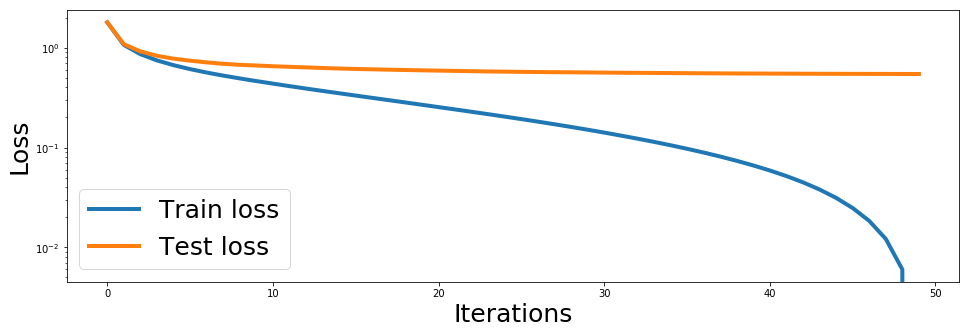

In [83]:
min_objective = min([min(train_loss_history), min(test_loss_history)])
plt.figure(figsize=(16,5))
plt.semilogy(train_loss_history-min_objective, lw=4, label='Train loss')
plt.semilogy(test_loss_history-min_objective, lw=4, label='Test loss')
plt.xlabel('Iterations', fontsize=25)
plt.ylabel('Loss', fontsize=25)
plt.legend(fontsize=25)
plt.show()

#### Results

Let us plot some random test data, and the predicted values for the GD approach and the SGD approach (for the KL/entropy loss). As the test losses show, the Stochastic Gradient Approach leads to slightly better predictions than the GD approach.

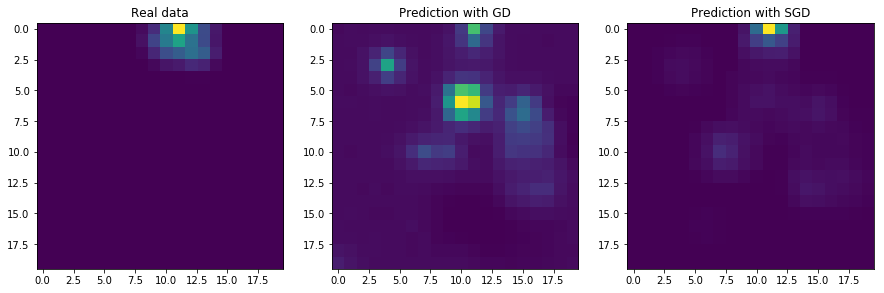

In [85]:
i = np.random.randint(X_test.shape[0])

pred_GD = network(X_test[i], A1_KL_GD, A2_KL_GD, b1_KL_GD, b2_KL_GD, True)
pred_SGD = network(X_test[i], A1_KL_SGD, A2_KL_SGD, b1_KL_SGD, b2_KL_SGD, True)

fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(y_test[i].reshape(20,20))
ax.set_title('Real data')

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(pred_GD.reshape(20,20))
ax2.set_title('Prediction with GD')

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(pred_SGD.reshape(20,20))
ax3.set_title('Prediction with SGD')

plt.show()